In [1]:
import pandas as pd
import numpy as np
import time as time
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [4]:
"""导入电力部门产出限制"""
OUTAGE_NUTS2 = pd.read_csv('D:/BaiduSyncdisk/TEMP/ARIO/data/NUTS2_thred_outage/duration_43.csv')
OUTAGE_NUTS2['Incident Time'] = pd.to_datetime(OUTAGE_NUTS2['Incident Time'])

TIM = len(OUTAGE_NUTS2['Incident Time'].unique())
print(TIM)

17166


In [5]:
"""
===========================================
1. 模型参数设置 - 真实MRIO数据
===========================================
"""
# 基本维度参数 - 真实数据规模
REG = 37         # 区域数量 (37个区域)
SEC = 61         # 部门数量 (61个部门)
F = 38           # 最终需求类别数量 (37个区域 + 1个出口)
R_S = REG * SEC  # 区域-部门组合总数 (37*61=2257)
S_R = REG * SEC  # 同上，备用变量  
# TIM = 31         # 时间序列长度 (31个时期)
UU = 1           # 增加值行数

# 电力部门设置
power_sec_idx = 23 # 电力部门索引 (第23个部门，从0开始计数)

# %%
"""
===========================================
2. 真实MRIO数据读取与预处理
===========================================
"""
# 文件路径设置
IO_PATH = "D:\\BaiduSyncdisk\\TEMP\\MRIOT\\MRIOT\\"
IOZPath = IO_PATH + "Final_Z.xlsx"        # 中间投入矩阵Z
IOFPath = IO_PATH + "F.xlsx"              # 最终需求矩阵F  
IOVPath = IO_PATH + "VA.xlsx"             # 增加值矩阵VA
ImportPath = IO_PATH + "Import.xlsx"      # 进口矩阵
ExportPath = IO_PATH + "Export.xlsx"      # 出口矩阵
REG_SEC_list_path = IO_PATH + "REG_SEC_list.xlsx"  # 区域部门列表

# 读取各个矩阵文件
print("正在读取MRIO数据文件...")

# 读取中间投入矩阵Z (R_S × R_S)
IOZ_0 = pd.read_excel(IOZPath, sheet_name=0, header=None, skiprows=3).iloc[:, 2:].to_numpy()

# 读取最终需求矩阵F (R_S × F)  
IOF_0 = pd.read_excel(IOFPath, sheet_name=0, header=None, skiprows=1).iloc[:, 2:].to_numpy()

# 读取增加值矩阵VA (UU × R_S)
IOV_0 = pd.read_excel(IOVPath, sheet_name=0, header=None, skiprows=3).iloc[:, 1:].to_numpy()

# 读取出口向量 (R_S × 1)
IOEX_0 = pd.read_excel(ExportPath, sheet_name=0, header=None, skiprows=1).iloc[:, 2:].to_numpy()

# 读取进口矩阵 (F × R_S)
IOIM_0 = pd.read_excel(ImportPath, sheet_name=0, header=None, skiprows=1).iloc[:, 1:].to_numpy()

# 读取列名标识
col_R_S = pd.read_excel(REG_SEC_list_path, sheet_name=0, usecols=[0]).squeeze().tolist()  # 区域-部门列名
col_F = pd.read_excel(REG_SEC_list_path, sheet_name=1).squeeze().tolist()                # 最终需求列名
col_all = col_R_S + col_F  # 合并所有列名
REG_SEC_list = pd.read_excel(REG_SEC_list_path, sheet_name=0).squeeze().tolist()         # 区域部门详细列表

print(f"数据读取完成 - 矩阵维度: Z({IOZ_0.shape}), F({IOF_0.shape}), VA({IOV_0.shape})")

# 数值安全处理：将所有零值替换为极小正数，避免后续计算中的除零错误
print("进行数值安全处理...")
IOZ_0[IOZ_0 == 0] = 1e-6   # 中间投入矩阵
IOF_0[IOF_0 == 0] = 1e-6   # 最终需求矩阵  
IOEX_0[IOEX_0 == 0] = 1e-6 # 出口矩阵
IOV_0[IOV_0 == 0] = 1e-6   # 增加值矩阵
IOIM_0[IOIM_0 == 0] = 1e-6 # 进口矩阵

"""
===========================================
3. 核心矩阵验证与基础计算
===========================================
"""
# 矩阵已通过文件直接读取，进行维度验证
print("矩阵维度验证:")
print(f"  中间投入矩阵 IOZ_0: {IOZ_0.shape} (应为 {R_S} × {R_S})")
print(f"  最终需求矩阵 IOF_0: {IOF_0.shape} (应为 {R_S} × {F})")  
print(f"  增加值矩阵 IOV_0: {IOV_0.shape} (应为 {UU} × {R_S})")
print(f"  出口向量 IOEX_0: {IOEX_0.shape} (应为 {R_S} × 1)")

# 核心矩阵说明:
# IOZ_0: 中间投入矩阵 (2257×2257) - 各区域各部门间的中间投入关系
# IOF_0: 最终需求矩阵 (2257×38) - 各区域各部门对最终需求的供应  
# IOV_0: 增加值矩阵 (1×2257) - 各区域各部门的增加值
# IOEX_0: 出口向量 (2257×1) - 各区域各部门的出口额

# 计算总产出向量 (Ghosh模型中为行和)
IOX_0 = np.sum(IOZ_0, axis=1) + np.sum(IOF_0, axis=1) + IOEX_0.flatten()
# 总产出 = 中间销售 + 最终需求销售 + 出口

# 验证产出计算
print(f"\n总产出向量维度: {IOX_0.shape}")
print(f"总产出统计: 最小值={IOX_0.min():.2f}, 最大值={IOX_0.max():.2f}, 平均值={IOX_0.mean():.2f}")

# 初始化时间序列总产出矩阵 (用于动态分析)
IOX_TIM = np.zeros((TIM, R_S))  # 形状: (31, 2257)

正在读取MRIO数据文件...
数据读取完成 - 矩阵维度: Z((2257, 2257)), F((2257, 37)), VA((1, 2257))
进行数值安全处理...
矩阵维度验证:
  中间投入矩阵 IOZ_0: (2257, 2257) (应为 2257 × 2257)
  最终需求矩阵 IOF_0: (2257, 37) (应为 2257 × 38)
  增加值矩阵 IOV_0: (1, 2257) (应为 1 × 2257)
  出口向量 IOEX_0: (2257, 1) (应为 2257 × 1)

总产出向量维度: (2257,)
总产出统计: 最小值=0.51, 最大值=82417.92, 平均值=1598.91


In [6]:
"""
===========================================
4. Ghosh模型系数计算
===========================================
Ghosh模型是供给驱动的IO模型，分析产出冲击如何向下游传播
"""
# 计算Ghosh技术系数矩阵 B = Z/X (按行标准化)
B = IOZ_0 / IOX_0[:, np.newaxis]  # B[i,j] = 部门i产出中销售给部门j的比例

# 计算Ghosh逆矩阵 G = (I-B)^(-1)
I = np.eye(R_S)  # 单位矩阵
G = np.linalg.inv(I - B)  # Ghosh乘数矩阵：衡量总体影响

# 构建部门聚合矩阵：将区域-部门组合按部门维度聚合
I_Sum = np.tile(np.eye(SEC), (1, REG))  # 形状(3, 12)的聚合矩阵

# 计算部门层面的Ghosh系数 (3x12)
Ghosh_C = np.dot(I_Sum, G)  # 各部门对各区域各部门的影响系数
"""
===========================================
5. 权重矩阵计算 - 真实数据规模
===========================================
构建反比权重矩阵：权重越小的部门，承担更多停电负担
"""
print("开始计算权重矩阵...")

# 初始化权重矩阵 (61×2257)
Ghosh_C_weighted = np.zeros_like(Ghosh_C, dtype=float)

# 对每个区域分别计算反比权重  
for reg in range(REG):  # 遍历37个区域
    col_start = reg * SEC        # 当前区域起始列 (reg*61)
    col_end = (reg + 1) * SEC    # 当前区域结束列 ((reg+1)*61)
    
    if reg % 10 == 0:  # 进度显示
        print(f"  处理区域 {reg+1}/{REG}")
    
    for row in range(SEC):       # 遍历61个部门
        # 提取该部门对当前区域各部门的影响系数
        row_slice = Ghosh_C[row, col_start:col_end]  # 长度为SEC的数组
        row_sum = row_slice.sum()
        
        if row_sum > 1e-10:  # 避免极小值导致的数值问题
            # 采用归一化反比权重法：影响系数越小，分担比例越高
            inverse_weights = 1.0 / (row_slice + 1e-12)  # 加小量避免除零
            # 归一化使权重之和为1
            Ghosh_C_weighted[row, col_start:col_end] = inverse_weights / np.sum(inverse_weights)

print("权重矩阵计算完成")
print(f"权重矩阵维度: {Ghosh_C_weighted.shape}")

# 验证电力部门权重分布
sample_reg = 0  # 检查第一个区域
power_weights_sample = Ghosh_C_weighted[power_sec_idx, sample_reg*SEC:(sample_reg+1)*SEC]
print(f"电力部门在区域{sample_reg+1}的权重分布: min={power_weights_sample.min():.6f}, max={power_weights_sample.max():.6f}")
print(f"权重和验证: {power_weights_sample.sum():.6f} (应接近1.0)")

"""
===========================================
6. 区域用电量计算 - 真实数据规模
===========================================
计算各区域各部门的用电量(中间投入)
"""
print("开始计算区域用电量...")

# 使用聚合矩阵将投入按部门维度求和
I_Sum = np.tile(np.eye(SEC), (1, REG))      # 部门聚合矩阵 (61, 2257)
IOZ_C_reg = np.dot(I_Sum, IOZ_0)            # 各部门对各区域部门的投入 (61, 2257)

print(f"聚合后投入矩阵维度: {IOZ_C_reg.shape}")

# 将投入矩阵重新组织为 (部门, 区域) 格式
IOZ_C_reg_sec = np.zeros((SEC, REG))        # 初始化 (61, 37) 矩阵

for reg in range(REG):
    col_start = reg * SEC
    col_end = (reg + 1) * SEC
    # 对每个区域，将其各部门的投入按行求和
    IOZ_C_reg_sec[:, reg] = np.sum(IOZ_C_reg[:, col_start:col_end], axis=1)

print(f"区域用电量矩阵维度: {IOZ_C_reg_sec.shape} (61个部门 × 37个区域)")

# 验证电力部门用电情况
power_consumption_by_region = IOZ_C_reg_sec[power_sec_idx, :]
print(f"电力部门用电统计: 最小值={power_consumption_by_region.min():.2f}, " +
      f"最大值={power_consumption_by_region.max():.2f}, " +
      f"平均值={power_consumption_by_region.mean():.2f}")


开始计算权重矩阵...
  处理区域 1/37
  处理区域 11/37
  处理区域 21/37
  处理区域 31/37
权重矩阵计算完成
权重矩阵维度: (61, 2257)
电力部门在区域1的权重分布: min=0.000008, max=0.242279
权重和验证: 1.000000 (应接近1.0)
开始计算区域用电量...
聚合后投入矩阵维度: (61, 2257)
区域用电量矩阵维度: (61, 37) (61个部门 × 37个区域)
电力部门用电统计: 最小值=110.95, 最大值=31692.84, 平均值=1862.95


In [7]:
"""
===========================================
7. 非线性停电分配函数 - 核心算法
===========================================
"""
def redistribute_limit(total_cons, weights, max_cap, gamma, tol=1e-8):
    """
    非线性停电分配算法
    目标：将总停电量在各部门间分配，优先让权重小的部门停电
    权重小的部门优先承担削减负担，当部门达到容量上限时，超出部分重新分配给其他部门。

    参数:
    total_cons (float): 区域总限电量，需要在各部门间分配的削减总量
    weights (array): 各部门权重向量，权重越小越优先承担削减任务
    max_cap (array): 各部门最大削减能力，为其用电量的95%
    gamma (float): 非线性放大系数，控制权重差异的放大程度 (默认为1)
    tol (float): 数值容忍误差，控制迭代终止条件

    返回:
    alloc (array): 各部门最终削减量分配结果

    算法逻辑:
    ----------
    1. 对权重进行指数放大 (weights^gamma)
    2. 按权重比例分配停电量
    3. 若某部门分配量超过其容量，先分配到容量上限
    4. 将超出部分重新分配给其他部门
    5. 迭代直到分配完毕
    """
    
    # 数据预处理
    weights = np.asarray(weights, dtype=float).copy() # shape=(61,) - 该区域61个部门的权重
    max_cap = np.asarray(max_cap, dtype=float).copy() # hape=(61,) - 该区域61个部门的最大削减能力

    # 通过指数运算扩大权重间差异 (gamma=1无差异)
    weights = np.power(np.maximum(weights, 0.0), gamma)
    if weights.sum() < tol:          
        weights[:] = 1.0
    
    # 初始化分配状态
    n = len(weights)                 # 部门数量
    alloc = np.zeros(n)              # 各部门已分配的削减量
    done = np.zeros(n, dtype=bool)   # 记各部门是否已达容量上限
    remaining = total_cons           # 剩余未分配的削减量

    # 迭代分配过程，直到削减量完全分配或所有部门达到上限
    while remaining > tol and not done.all(): #还有未分配的电量 & 还有未满容量的部门

        # 每轮都重新计算部门权重总和，确保剩余削减量总是在当前仍有容量空间的部门间按正确比例分配
        active_weights = weights[~done].sum()
        if active_weights < tol:
            break  # 所有权重为零，无法继续分配

        # 对每个部门尝试分配
        for i in range(n):
            if done[i]:  # 跳过已满容量的部门
                continue

            # 按权重比例计算该部门应分配量
            share = remaining * weights[i] / active_weights
            
            # 计算该部门剩余容量
            room = max_cap[i] - alloc[i]

            if share >= room - tol:   # 应分配的容量超过了用电量（可分配容量）上线
                alloc[i] += room      # 只分配到容量上限
                remaining -= room     # 减少剩余量
                done[i] = True        # 标记为已满
            else:                     # 不超容量
                alloc[i] += share     # 全部分配
                remaining -= share

            # 提前终止条件
            if remaining <= tol:
                break

    return alloc # alloc的shape是(SEC,)，即(61,)，代表一个区域内各部门的电力削减量分配

In [18]:
"""
===========================================
8. 真实电力约束数据集成
===========================================
引入OUTAGE_2040数据，构建真实的电力供应约束矩阵
"""
print("开始集成真实电力约束数据...")

# 导入电力部门产出限制
# columns = Index(['Unnamed: 0', 'nuts218cd', 'Incident Date', 'Weighted_County_outage'], dtype='object')
# 预处理电力约束数据
# OUTAGE_NUTS2 = pd.read_csv('D:/BaiduSyncdisk/TEMP/ARIO/data/NUTS2_thred_outage/duration_1.csv')
# OUTAGE_NUTS2['Incident Time'] = pd.to_datetime(OUTAGE_NUTS2['Incident Time'])

# 创建 UKN0 区域的零约束数据
UKN0 = OUTAGE_NUTS2[['Incident Time']].drop_duplicates()
UKN0['nuts218cd'] = 'UKN0'
UKN0['Total_Daily_Period'] = 0

# 合并原数据和 UKN0
OUTAGE_NUTS2 = pd.concat([OUTAGE_NUTS2, UKN0], ignore_index=True)
OUTAGE_NUTS2 = OUTAGE_NUTS2.sort_values(['nuts218cd', 'Incident Time'])

OUTAGE_NUTS2['Total_Daily_Period'] = 1 - (OUTAGE_NUTS2['Total_Daily_Period'] / 24.0001)
OUTAGE_NUTS2 = OUTAGE_NUTS2.reset_index(drop=True)
OUTAGE_NUTS2 = OUTAGE_NUTS2[['nuts218cd', 'Incident Time', 'Total_Daily_Period']]

NUTS2_LIST = OUTAGE_NUTS2['nuts218cd'].unique().tolist()

开始集成真实电力约束数据...


In [ ]:

# """ 选取 2040 年的时间段作为实验"""
# TIMESPAN = pd.date_range('2040-01-01', '2040-12-31', freq='D')
# OUTAGE_2040 = OUTAGE_NUTS2[OUTAGE_NUTS2['Incident Time'].isin(TIMESPAN)].copy()
# OUTAGE_2040_temp = OUTAGE_2040.copy()

# OUTAGE_2040['Total_Daily_Period'] = 1 - (OUTAGE_2040['Total_Daily_Period'] / 24.0001)
# OUTAGE_2040 = OUTAGE_2040.reset_index(drop=True)
# OUTAGE_2040 = OUTAGE_2040[['nuts218cd', 'Incident Time', 'Total_Daily_Period']]

# NUTS2_LIST = OUTAGE_2040['nuts218cd'].unique().tolist()

# # 合并所有地区的停电时间
# OUTAGE_NUTS2_ps_aggregated = OUTAGE_2040_temp.groupby('Incident Time')['Total_Daily_Period'].sum().reset_index()

# # 判断是否是单一地区停电
# OUTAGE_if_mul_region = OUTAGE_2040_temp.groupby('Incident Time').agg({
#     'Total_Daily_Period': lambda x: (x > 0).sum()  # 统计停电小时数>0的区域数量
# }).reset_index()

# OUTAGE_if_mul_region['if_mul_region'] = OUTAGE_if_mul_region['Total_Daily_Period'].apply(
#     lambda x: 'Yes' if x > 1 else 'No'
# )

# OUTAGE_NUTS2_ps_aggregated = OUTAGE_NUTS2_ps_aggregated.merge(
#     OUTAGE_if_mul_region[['Incident Time', 'if_mul_region']], 
#     on='Incident Time', 
#     how='left'
# )

In [20]:
"""
===========================================
8. 模型应用示例 - 真实数据测试
===========================================
模拟某个区域的电力部门受到冲击的情况
"""

# 获取区域数量并验证
NUTS2_LIST = OUTAGE_NUTS2['nuts218cd'].unique().tolist()
num_regions = len(NUTS2_LIST)
if num_regions != REG:
    print(f"调整REG参数: {REG} -> {num_regions}")
    REG = num_regions
    R_S = REG * SEC

# # 创建区域映射字典
region_to_index = {region: i for i, region in enumerate(NUTS2_LIST)}
time_to_index = {time: i for i, time in enumerate(OUTAGE_NUTS2['Incident Time'].unique())}
TIM = len(time_to_index)

print(f"数据概览:")
print(f"  区域数: {num_regions}")
print(f"  时间点数: {TIM}")
# print(f"  约束记录数: {len(OUTAGE_2040)}")

print("开始基于真实约束的非线性分配...")

# 初始化两个约束矩阵
# Power_CONS: (部门×区域×时间) - 电力部门对各区域的直接约束
# Power_CONS_C: (部门×区域-部门×时间) - 考虑部门间分配的最终约束矩阵
Power_CONS = np.ones((SEC, REG, TIM))
Power_CONS_C = np.ones((SEC, R_S, TIM))
print(f"初始化Power_CONS_C矩阵: {Power_CONS_C.shape}")

# 统计变量
total_cases = len(OUTAGE_NUTS2)
processed_cases = 0
valid_cases = 0

print(f"处理 {total_cases} 条约束记录...")

# 遍历OUTAGE_NUTS2的每条记录
for idx, row in OUTAGE_NUTS2.iterrows():
    nuts_code = row['nuts218cd']
    incident_time = row['Incident Time'] 
    constraint_level = row['Total_Daily_Period']
    
    processed_cases += 1
    
    # 获取索引
    reg_idx = region_to_index[nuts_code]
    time_idx = time_to_index[incident_time]
    
    # 如果是100%供应（无约束），跳过
    if constraint_level >= 1.0:
        continue
        
    valid_cases += 1 # 统计真正需要进行非线性分配计算的记录数量
    
    # 详细处理前5个有效案例
    if valid_cases <= 5:
        print(f"\n--- 案例 {valid_cases}: 区域{nuts_code}, 时间{incident_time}, 约束{constraint_level:.3f} ---")
    
    # 确保每个区域的电力约束只影响该区域内的部门，不会串扰到其他区域
    col_start = reg_idx * SEC  # 计算该区域在矩阵中的起始列索引
    col_end = (reg_idx + 1) * SEC  # 计算该区域在矩阵中的结束列索引
    
    # 从Ghosh系数矩阵中提取电力部门对该区域所有部门的权重
    weights = Ghosh_C_weighted[power_sec_idx, col_start:col_end]
    
    # 计算电力削减比例（1 - 供应水平 = 削减比例）
    power_reduction_rate = 1 - constraint_level  
    
    # 计算该区域总的电力削减量（区域电力消耗 × 削减比例）
    total_cons = IOZ_C_reg_sec[power_sec_idx, reg_idx] * power_reduction_rate

    # 获取该区域各部门的最大电力消耗容量（作为分配上限）(为每个部门保留5%的用电量)
    max_cap = IOZ_C_reg[power_sec_idx, col_start:col_end] * 0.9
    
    # 打印详细信息（仅前5个案例）
    if valid_cases <= 5:
        print(f"  削减比例: {power_reduction_rate*100:.1f}%, 总限电量: {total_cons:.2f}")
    
    # 执行非线性电力分配算法
    # total_cons: 总削减量
    # weights: 各部门权重（基于Ghosh系数）
    # max_cap: 各部门最大消耗容量
    # gamma: 非线性参数，控制分配的集中度
    alloc = redistribute_limit(
        total_cons,
        weights, 
        max_cap,
        gamma=1
    )
    
    if valid_cases <= 5:
        print(f"  分配验证: 分配量{alloc.sum():.2f} vs 目标{total_cons:.2f}")
        print(f"  受影响部门: {np.sum(alloc > 1e-6)}/{SEC}")
        
    # 填入Power_CONS矩阵：电力部门对区域的直接约束
    Power_CONS[power_sec_idx, reg_idx, time_idx] = constraint_level
    # 计算剩余供应比例并填入Power_CONS_C矩阵
    # 只修改电力部门的供应约束
    # 遍历该区域的所有部门，更新电力供应约束
    for i in range(SEC):
        sector_col_start = reg_idx * SEC + i  # 计算该部门在R_S维度的索引
        original_consumption = IOZ_C_reg[power_sec_idx, sector_col_start]  # 获取原始电力消耗
        if original_consumption > 1e-6:  # 仅对有实际消耗的部门进行约束调整
            # 计算剩余供应比例（分配后剩余/原始消耗）
            remaining_supply = (original_consumption - alloc[i]) / original_consumption
            Power_CONS_C[power_sec_idx, sector_col_start, time_idx] = max(remaining_supply, 1e-6)

# 数值安全处理
Power_CONS_C[Power_CONS_C <= 0] = 1e-6

# 结果汇总
print(f"\n" + "="*60)
print("非线性分配处理完成")
print("="*60)
print(f"总记录数: {total_cases}")
print(f"有效案例数: {valid_cases}")
print(f"停电比例: {valid_cases/total_cases*100:.1f}%") 

# 分析Power_CONS_C矩阵
constrained_elements = Power_CONS_C[Power_CONS_C < 1.0]
print(f"\nPower_CONS_C矩阵统计:")
print(f"  矩阵形状: {Power_CONS_C.shape}")
print(f"  约束元素数: {len(constrained_elements)}")
print(f"  约束比例: {len(constrained_elements)/Power_CONS_C.size*100:.3f}%")

if len(constrained_elements) > 0:
    print(f"  约束强度: {constrained_elements.min():.3f} - {constrained_elements.max():.3f}")
    print(f"  平均约束: {constrained_elements.mean():.3f}")

# 验证电力部门的约束情况
power_sector_constraints = Power_CONS_C[power_sec_idx, :, :]
power_constrained = power_sector_constraints[power_sector_constraints < 1.0]
print(f"  电力部门约束点: {len(power_constrained)} 个")

print("\n✓ 基于真实OUTAGE_NUTS2数据的Power_CONS_C矩阵构建完成")
print("✓ 可用于后续冲击传播分析")

数据概览:
  区域数: 37
  时间点数: 17166
开始基于真实约束的非线性分配...
初始化Power_CONS_C矩阵: (61, 2257, 17166)
处理 652308 条约束记录...

--- 案例 1: 区域UKC1, 时间2023-02-15 00:00:00, 约束0.958 ---
  削减比例: 4.2%, 总限电量: 25.44
  分配验证: 分配量25.44 vs 目标25.44
  受影响部门: 61/61

--- 案例 2: 区域UKC1, 时间2023-03-10 00:00:00, 约束0.792 ---
  削减比例: 20.8%, 总限电量: 127.18
  分配验证: 分配量127.18 vs 目标127.18
  受影响部门: 61/61

--- 案例 3: 区域UKC1, 时间2023-07-24 00:00:00, 约束0.958 ---
  削减比例: 4.2%, 总限电量: 25.44
  分配验证: 分配量25.44 vs 目标25.44
  受影响部门: 61/61

--- 案例 4: 区域UKC1, 时间2023-12-23 00:00:00, 约束0.750 ---
  削减比例: 25.0%, 总限电量: 152.62
  分配验证: 分配量152.62 vs 目标152.62
  受影响部门: 61/61

--- 案例 5: 区域UKC1, 时间2024-09-02 00:00:00, 约束0.958 ---
  削减比例: 4.2%, 总限电量: 25.44
  分配验证: 分配量25.44 vs 目标25.44
  受影响部门: 61/61

非线性分配处理完成
总记录数: 652308
有效案例数: 8767
停电比例: 1.3%

Power_CONS_C矩阵统计:
  矩阵形状: (61, 2257, 17166)
  约束元素数: 534787
  约束比例: 0.023%
  约束强度: 0.100 - 1.000
  平均约束: 0.464
  电力部门约束点: 534787 个

✓ 基于真实OUTAGE_NUTS2数据的Power_CONS_C矩阵构建完成
✓ 可用于后续冲击传播分析


In [21]:
print("约束强度分布:")
print(OUTAGE_NUTS2[OUTAGE_NUTS2['Total_Daily_Period'] < 1.0]['Total_Daily_Period'].describe())

约束强度分布:
count    8767.000000
mean        0.908953
std         0.120915
min         0.000004
25%         0.916667
50%         0.958334
75%         0.958334
max         0.958334
Name: Total_Daily_Period, dtype: float64


In [22]:
"""Identify the production fuction"""
# Function to calculate production output
def production(StockMat, COE_A, IOV_t, COE_VA, ORDER, IOX_0):
    # Calculate output driven by stock and value-added
    Stock_X = StockMat / COE_A
    V_X = IOV_t / COE_VA
    O_X = np.sum(ORDER, axis=1, keepdims=True).T
    # temp = 1.25 * IOX_0[np.newaxis, :]   # 考虑最大生产能力
    # Stock_X[mat_key] = temp[mat_key] # only important sector goes into function # 关键部门的损失减少才会反映在总损失减少内，否则保持最大生产能力
    # Return minimum output based on stock, VA, and order
    return np.min(np.vstack([Stock_X, V_X, O_X]), axis=0)

# Function to calculate maximum production output
def production_max(StockMat, COE_A, IOV_t, COE_VA):
    Stock_X = StockMat / COE_A
    V_X = IOV_t / COE_VA
    # temp = 1.25 * IOX_0[np.newaxis, :]   
    # Stock_X[mat_key] = temp[mat_key] # only important sector goes into function
    # Return minimum output between stock and value-added constraints
    return np.min(np.vstack([Stock_X, V_X]), axis=0)

In [23]:
"""Identify initail variables"""

# Initialize matrices for the time period. 本案例中，一月一共有三十一天，因此制作三十一个维度的矩阵
IOX_TIM = np.zeros((TIM, R_S))
IOX_TIM_max = np.zeros((TIM, R_S)) # 

# Compute stock and production coefficients
I_Sum = np.tile(np.eye(SEC), (1, REG))  # I Matrix 
IOZ_C = np.dot(I_Sum, IOZ_0)  # Z Combine regions 行方向合并了所有的区域。隐含假设：不同地区相同部门的产品可以替代。因此不考虑区域差异和专业化生产。

# Distribute toal intermediate use for each sector into each region 计算来自不同区域的订单比例(各地区各部门之间的中间使用量占该部门总中间使用量的比例)
Z_Dis = IOZ_0 / np.tile(IOZ_C, (REG,1)) 
# 创建一个与Z_Dis形状相同的矩阵,默认值为6
StockCoef = np.full_like(IOZ_C, 18)
StockCoef[power_sec_idx,:] = 1.10
StockMat = StockCoef*IOZ_C  # Stock = 6 times of intermediate use 
StockObj = StockMat + IOZ_C # Objected stock
#np.repeat(np.arange(3), 4) 每行重复四次
IOF_C = np.dot(I_Sum, IOF_0)  # F Combine regions 
F_Dis = IOF_0 / np.tile(IOF_C, (REG, 1)) # Similar to Z_Dis

# np.newaxis 在 IOF_0 的第三个维度上增加一个维度，使其形状变为 (NNRR, RR, 1),repeat 将 IOF_0[:, :, np.newaxis] 在第三个维度（axis=2）上重复 TIM 次。 IOF_TIM 的形状为 (NNRR, RR, TIM)
IOF_TIM = np.repeat(IOF_0[:, :, np.newaxis], TIM, axis=2) #  F x TIME

# # 设置出口矩阵(先假设不考虑对出口的影响)
IOEX_C = np.dot(I_Sum, IOEX_0)
EX_Dis = IOEX_0 / np.tile(IOEX_C, (REG, 1))

# Coefficients for production calculations
COE_A = np.dot(IOZ_C, np.diag(1 / IOX_0))  # Coefficient A for combined Z
COE_VA = np.dot(IOV_0, np.diag(1 / IOX_0)) # Coefficient VA 

Labor_Cons = np.ones((SEC, REG, TIM)) 
ORDER = np.hstack((IOZ_0, IOF_0, IOEX_0))  # 添加出口项
print("ORDER sum vs IOX_0:", np.sum(ORDER, axis=1)[:5], IOX_0[:5])

ORDER sum vs IOX_0: [ 366.35191491    7.59845216   17.26656356  389.82145035 2106.13040504] [ 366.35191491    7.59845216   17.26656356  389.82145035 2106.13040504]


In [24]:
for t in range(1, TIM+1):
    if t % 50 == 0:
         print(f"[DEBUG] STEP: {t} --- id={id(t)}")
    #----------------------------------------------------------------
    # t=3
    IOV_Cons = np.zeros((UU, R_S)) # (UU=1 means only 1 row of VA)
    IOV_Cons[0, ] = Labor_Cons[:, :, t-1].reshape(1, -1)  # Constrain of value_added 目前的情况下全部为1 表示没有劳动力限制
    
    # # Calculate production under constraints
    # IOV_t = IOV_0 * IOV_Cons * Over_PROD # Constrain of IOV  t时的增加值（劳动力）的生产能力。在Over_PROD和IOV_Cons都为1的情况下，IOV_t = IOV_0
    IOV_t = IOV_0 * IOV_Cons
    
    # 库存可以生产的数量和劳动力约束可以生产的数量取最小值。在初期应该是劳动力约束下的生产数量较小。
    # 在Stock 和 VA_CONS可以实现的产出 上取最小值
    # 在VA_CONS = 1 的情况下，IOX_t_max = IOX_0。
    IOX_t_max = production_max(StockMat, COE_A, IOV_t, COE_VA) # Max output under constrain of value_added
    IOX_t_max = IOX_t_max.reshape(1, -1)
    
    # Actual production based on order and constraints
    # 在Stock VA_CONS 和 ORDER之间取最小值
    IOX_t = production(StockMat, COE_A, IOV_t, COE_VA, ORDER, IOX_0) # actual production in t, depends on order and 初始生产能力 IOX_0
    IOX_t = IOX_t.reshape(1, -1)
    
    # Max distribute ability = 'share of each order in total order' * 'Max output under constrain'
    # 计算最大订单分配能力 IOX_t_Dis_max，基于订单比例和最大生产能力
    # Order是X+F+EX;ORDER / np.sum(ORDER, axis=1)是每一个区域和部门需要的投入占总产出的比例；乘以t期的总产出可以得到t期总产出按照原有比例进行的分配。
    IOX_t_Dis_max = (ORDER / np.sum(ORDER, axis=1, keepdims=True)) * np.tile(IOX_t_max, (R_S + F, 1)).T # F表示final demand 的列数
    
    # Actual distribute of Order
    IOX_t_Dis = (ORDER / np.sum(ORDER, axis=1, keepdims=True)) * np.tile(IOX_t, (R_S + F, 1)).T
    
    # Stock Change
    StockUse = np.tile(IOX_t, (SEC, 1)) * COE_A # Stockuse = actual production * COE_A ·基于实际生产能力和系数矩阵 COE_A 逐元素相乘
    StockAdd = np.dot(I_Sum, IOX_t_Dis[:, :R_S]) # Actual distribute of Order；t期产出的分配是为了弥补库存需求，因此中间品在t期的实际分配乘I_sum以后可以得到每一个部门存量的增加。
    StockMat = StockMat - StockUse + StockAdd # 更新库存矩阵 StockMat，减去库存使用量，加上库存增加量
    StockGap = StockObj - StockMat
    StockGap[StockGap < 0] = 0 # 将库存缺口中小于 0 的值设为 0，表示不需要补充库存
    
    #-------------------------------------------------------------------------- 
    # Adjust order distribution based on power blackouts

    min_IOV_Cons = np.min(IOV_Cons, axis=0)
    
    # Power_T = Power_CONS[:, :, t-1]
    # 这里直接调用了 (SEC, SEC*REG)的限制矩阵
    Power_T = Power_CONS_C[:, :, t-1]
    Power_T = np.tile(Power_T, (REG, 1))
    # Power_T = np.tile(Power_T, (REG, 1))[:, np.repeat(np.arange(REG), SEC)]

    # 交通和劳动力约束后的实际Z_dis，乘电力约束
    # 行方向是61行，采用np.tile拓展区域。列方向为37列，每一个区域采用np.repeat拓展部门
    Power_Z_Dis = Z_Dis * Power_T * np.tile(min_IOV_Cons, (R_S, 1)) #无约束时
    Power_Z_C = np.dot(I_Sum,  Power_Z_Dis) 
    ACTUAL_Power_Z_Dis = Power_Z_Dis / np.tile(Power_Z_C, (REG, 1)) # 电力约束下的Z分配比例

    # 进行停电约束下的订单分配
    # Final actual order (Fixed np.repeat syntax)  更新订单矩阵 ORDER 的前 R_S 列，根据库存的需求*实际订单分配比例
    ORDER[:, :R_S] = np.tile(StockGap, (REG, 1)) * ACTUAL_Power_Z_Dis 
        
    Order_I_Z = ORDER[:, :R_S] # order for initial intermidate use
    Order_T_Z = IOZ_0 * Power_T # order for trans constrin intermidate use
    Order_I_Z = np.where(Order_T_Z < Order_I_Z, Order_T_Z, Order_I_Z) 
    #np.where(condition, x, y) 是一个条件赋值函数：如果 condition 为 True，则取 x 的值；False，则取 y 的值。
    # 如果供给（Order_T_Z）小于需求（Order_I_Z，交通约束下Z的分配），则Order取决于供给，否则取决于需求

    ORDER[:, :R_S] = Order_I_Z # 重新设置订单Z的部门
    
    # 计算电力限制下的最终需求的分配。
    # Adjust F distribution under transport constraints
    Power_T = Power_CONS[:, :, t-1]
    Power_T = np.tile(Power_T, (REG, 1))
    Power_F_Dis = F_Dis * Power_T * np.tile(min_IOV_Cons[:, np.newaxis], (1, REG)) #np.repeat(min_IOV_Cons, REG, axis=0).T 
    Power_F_Dis_C = np.dot(I_Sum, Power_F_Dis)
        
    # Order_I_F = ORDER[:, R_S:-1]
    Order_I_F = ORDER[:, R_S:-1]
    Order_T_F = IOF_0 * Power_T
    Order_I_F = np.where(Order_T_F < Order_I_F, Order_T_F, Order_I_F)
    # ORDER[:, R_S:-1] = Order_I_F
    ORDER[:, R_S:-1] = Order_I_F

    # # 计算电力限制下的出口分配(先假设不考虑对出口的影响)
    Power_T = Power_CONS[:, :, t-1]
    # 提取所有列并拼接
    Power_T = Power_T.ravel(order='F').reshape(-1,1)# 按列展平
    Power_EX_Dis = EX_Dis * Power_T * np.tile(min_IOV_Cons[:, np.newaxis], (1, 1)) #np.repeat(min_IOV_Cons, REG, axis=0).T 
    Power_EX_Dis_C = np.dot(I_Sum, Power_EX_Dis)
        
    Order_I_EX = ORDER[:, -1:]
    Order_T_EX = IOEX_0 * Power_T
    Order_I_EX = np.where(Order_T_EX < Order_I_EX, Order_T_EX, Order_I_EX)
    ORDER[:, -1:] = Order_I_EX
    
    IOX_TIM[t-1, :] = IOX_t
    IOX_TIM_max[t-1, :] = IOX_t_max
    
    df_IOX_TIM = pd.DataFrame(IOX_TIM)
    df_IOX_TIM_max = pd.DataFrame(IOX_TIM_max) # 这个是用来追踪什么的
    
    # Production Ratio Visualization
    production_ratio = np.sum(IOX_TIM, axis=1) / np.sum(IOX_0) 
print("end")      

[DEBUG] STEP: 50 --- id=140718322800968
[DEBUG] STEP: 100 --- id=140718322802568
[DEBUG] STEP: 150 --- id=140718322804168
[DEBUG] STEP: 200 --- id=140718322805768
[DEBUG] STEP: 250 --- id=140718322807368
[DEBUG] STEP: 300 --- id=2084766449200
[DEBUG] STEP: 350 --- id=2084630095792
[DEBUG] STEP: 400 --- id=2084766446128
[DEBUG] STEP: 450 --- id=2084630095792
[DEBUG] STEP: 500 --- id=2084766446064
[DEBUG] STEP: 550 --- id=2084630095792
[DEBUG] STEP: 600 --- id=2084766445168
[DEBUG] STEP: 650 --- id=2084630095792
[DEBUG] STEP: 700 --- id=2084766447856
[DEBUG] STEP: 750 --- id=2084630095792
[DEBUG] STEP: 800 --- id=2084766449584
[DEBUG] STEP: 850 --- id=2084630095792
[DEBUG] STEP: 900 --- id=2084766448016
[DEBUG] STEP: 950 --- id=2084630095792
[DEBUG] STEP: 1000 --- id=2084766446032
[DEBUG] STEP: 1050 --- id=2084630095792
[DEBUG] STEP: 1100 --- id=2084766449488
[DEBUG] STEP: 1150 --- id=2084630095792
[DEBUG] STEP: 1200 --- id=2084766449296
[DEBUG] STEP: 1250 --- id=2084630095792
[DEBUG] ST

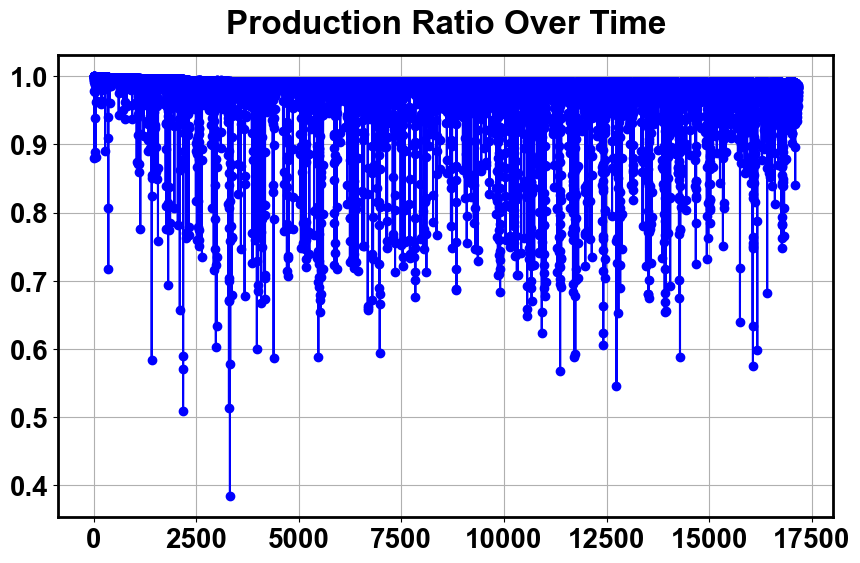

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, TIM + 1), production_ratio, marker='o', linestyle='-', color='b', label="Production Ratio")
plt.xlabel("", fontsize=20, fontweight='bold', fontname='Arial')
plt.ylabel("", fontsize=20, fontweight='bold', fontname='Arial')
plt.title("Production Ratio Over Time", fontsize=24, fontweight='bold', fontname='Arial', pad=16)
plt.xticks(fontsize=20, fontweight='bold', fontname='Arial')
plt.yticks(fontsize=20, fontweight='bold', fontname='Arial')
# plt.legend()
plt.grid(False)
plt.grid(True)
# 加粗坐标轴线条
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

plt.show()

In [26]:
baseline_output = np.sum(IOX_0)       #
actual_output   = np.sum(IOX_TIM) / TIM # 本期实际产出
loss = baseline_output - actual_output
print(loss/baseline_output*100)

2.1951962117940234


In [27]:
# 将time_to_index的键（时间戳）提取为列表
time_index = list(time_to_index.keys())

# 将IOX_TIM转换为DataFrame，并设置行索引为时间戳
df_IOX_TIM.index = time_index

# 验证结果
print(df_IOX_TIM.head())

                  0         1          2           3            4     \
2023-01-01  366.351915  7.598452  17.266564  389.821450  2106.130405   
2023-01-02  366.351915  7.598452  17.266564  389.821450  2106.130405   
2023-01-03  366.351915  7.598452  17.266564  389.821450  2106.130405   
2023-01-04  366.351905  7.598451  17.266564  389.788850  2106.130133   
2023-01-05  366.351078  7.597293  17.266546  389.801728  2106.030791   

                   5          6           7         8            9     ...  \
2023-01-01  1567.137108  43.385956  125.489689  6.244894  1255.771689  ...   
2023-01-02  1567.137108  43.385956  125.489689  6.244894  1255.771689  ...   
2023-01-03  1567.137108  43.385956  125.489689  6.244894  1255.771689  ...   
2023-01-04  1567.137106  43.385953  125.489625  6.244890  1255.764796  ...   
2023-01-05  1567.108709  43.381594  125.467300  6.243283  1254.566068  ...   

                  2247         2248         2249         2250         2251  \
2023-01-01  197.2025

In [34]:
df_IOX_TIM.to_csv('D:/BaiduSyncdisk/TEMP/ARIO/outputs/loss_2023_2070.csv', index_label='Date')

In [33]:
# 分析production_ratio的波动情况
print("="*80)
print("Production Ratio波动分析")
print("="*80)
time_index = list(time_to_index.keys())
time_index = np.array(time_index)  

# 计算每日的production ratio
daily_ratios = np.sum(IOX_TIM, axis=1) / np.sum(IOX_0)

print(f"Production Ratio基础统计:")
print(f"  数据点数: {len(daily_ratios)}")
print(f"  最小值: {daily_ratios.min():.6f}")
print(f"  最大值: {daily_ratios.max():.6f}")
print(f"  平均值: {daily_ratios.mean():.6f}")
print(f"  标准差: {daily_ratios.std():.6f}")

# 找出最小值（最大下降）的日期
min_ratio_idx = np.argmin(daily_ratios)
min_ratio_value = daily_ratios[min_ratio_idx]
min_ratio_date = time_index[min_ratio_idx]

print(f"\n最大波动（最低点）分析:")
print(f"  日期: {min_ratio_date.strftime('%Y-%m-%d')} (第{min_ratio_idx+1}天)")
print(f"  Production Ratio: {min_ratio_value:.6f}")
print(f"  经济损失: {(1-min_ratio_value)*100:.3f}%")

# 找出波动最大的几个日期
ratio_changes = np.abs(np.diff(daily_ratios))  # 计算相邻日期的变化幅度
max_change_idx = np.argmax(ratio_changes)
max_change_value = ratio_changes[max_change_idx]

print(f"\n最大日变化分析:")
print(f"  变化日期: 第{max_change_idx+1}天 → 第{max_change_idx+2}天")
print(f"  对应日期: {time_index[max_change_idx].strftime('%Y-%m-%d')} → {time_index[max_change_idx+1].strftime('%Y-%m-%d')}")
print(f"  变化幅度: {max_change_value:.6f}")
print(f"  变化前ratio: {daily_ratios[max_change_idx]:.6f}")
print(f"  变化后ratio: {daily_ratios[max_change_idx+1]:.6f}")

# 分析最低点当天的约束情况
# 获取最低点前两天的约束情况
two_days_before = min_ratio_date - pd.Timedelta(days=2)
constraints_two_days_before = OUTAGE_NUTS2[OUTAGE_NUTS2['Incident Time'] == two_days_before]
constrained_regions_two_days_before = constraints_two_days_before[constraints_two_days_before['Total_Daily_Period'] < 1.0]

print(f"\n最低点前两天约束情况 ({two_days_before.strftime('%Y-%m-%d')}):")
print(f"  受约束区域数: {len(constrained_regions_two_days_before)}/{len(NUTS2_LIST)}")
if len(constrained_regions_two_days_before) > 0:
    print(f"  受约束区域: {list(constrained_regions_two_days_before['nuts218cd'])}")
    print(f"  约束强度: {constrained_regions_two_days_before['Total_Daily_Period'].min():.3f} - {constrained_regions_two_days_before['Total_Daily_Period'].max():.3f}")
    print(f"  平均约束: {constrained_regions_two_days_before['Total_Daily_Period'].mean():.3f}")

# 打印最低点当天的约束情况
worst_day_constraints = OUTAGE_NUTS2[OUTAGE_NUTS2['Incident Time'] == min_ratio_date]
constrained_regions = worst_day_constraints[worst_day_constraints['Total_Daily_Period'] < 1.0]

print(f"\n最低点当天约束情况 ({min_ratio_date.strftime('%Y-%m-%d')}):")
print(f"  受约束区域数: {len(constrained_regions)}/{len(NUTS2_LIST)}")
if len(constrained_regions) > 0:
    print(f"  受约束区域: {list(constrained_regions['nuts218cd'])}")
    print(f"  约束强度: {constrained_regions['Total_Daily_Period'].min():.3f} - {constrained_regions['Total_Daily_Period'].max():.3f}")
    print(f"  平均约束: {constrained_regions['Total_Daily_Period'].mean():.3f}")

# 找出所有显著下降的日期（低于0.95）
significant_drops = daily_ratios < 0.95
drop_dates = time_index[significant_drops]
drop_values = daily_ratios[significant_drops]

print(f"\n所有显著下降日期 (ratio < 0.95):")
print(f"  下降事件数: {len(drop_dates)}")
if len(drop_dates) > 0:
    print(f"  下降日期列表:")
    for i, (date, ratio) in enumerate(zip(drop_dates, drop_values)):
        if i < 10:  # 只显示前10个
            day_num = np.where(time_index == date)[0][0] + 1
            print(f"    第{day_num:2d}天 ({date.strftime('%Y-%m-%d')}): {ratio:.6f} (损失{(1-ratio)*100:.2f}%)")
        elif i == 10:
            print(f"    ... (还有{len(drop_dates)-10}个)")
            break

# 分析波动模式
print(f"\n波动模式分析:")
print(f"  总变化次数: {len(ratio_changes)}")
print(f"  平均日变化: {ratio_changes.mean():.6f}")
print(f"  最大日变化: {ratio_changes.max():.6f}")
print(f"  变化幅度>0.001的天数: {np.sum(ratio_changes > 0.001)}")

# 验证图表中的具体数值
print(f"\n图表关键点验证:")
print(f"  第1天: {daily_ratios[0]:.6f}")
print(f"  第{min_ratio_idx+1}天(最低): {daily_ratios[min_ratio_idx]:.6f}")
print(f"  最后一天: {daily_ratios[-1]:.6f}")

Production Ratio波动分析
Production Ratio基础统计:
  数据点数: 17166
  最小值: 0.383609
  最大值: 1.000000
  平均值: 0.978048
  标准差: 0.044921

最大波动（最低点）分析:
  日期: 2032-02-05 (第3323天)
  Production Ratio: 0.383609
  经济损失: 61.639%

最大日变化分析:
  变化日期: 第3322天 → 第3323天
  对应日期: 2032-02-04 → 2032-02-05
  变化幅度: 0.598868
  变化前ratio: 0.982477
  变化后ratio: 0.383609

最低点前两天约束情况 (2032-02-03):
  受约束区域数: 33/37
  受约束区域: ['UKC1', 'UKD1', 'UKD3', 'UKD4', 'UKD6', 'UKD7', 'UKE1', 'UKE2', 'UKE3', 'UKE4', 'UKF1', 'UKF2', 'UKF3', 'UKG1', 'UKG2', 'UKG3', 'UKH1', 'UKH2', 'UKH3', 'UKI1', 'UKI2', 'UKJ1', 'UKJ2', 'UKJ3', 'UKJ4', 'UKK1', 'UKK2', 'UKK3', 'UKK4', 'UKL1', 'UKL2', 'UKM3', 'UKM6']
  约束强度: 0.000 - 0.958
  平均约束: 0.437

最低点当天约束情况 (2032-02-05):
  受约束区域数: 1/37
  受约束区域: ['UKD4']
  约束强度: 0.917 - 0.917
  平均约束: 0.917

所有显著下降日期 (ratio < 0.95):
  下降事件数: 1419
  下降日期列表:
    第18天 (2023-01-18): 0.879813 (损失12.02%)
    第35天 (2023-02-04): 0.888575 (损失11.14%)
    第44天 (2023-02-13): 0.938294 (损失6.17%)
    第56天 (2023-02-25): 0.881063 (损失11.89%)
  

In [ ]:
# # 合并所有地区的停电时间
# OUTAGE_NUTS2_ps_aggregated = OUTAGE_2040_temp.groupby('Incident Time')['Total_Daily_Period'].sum().reset_index()

# # 判断是否是单一地区停电
# OUTAGE_if_mul_region = OUTAGE_2040_temp.groupby('Incident Time').agg({
#     'Total_Daily_Period': lambda x: (x > 0).sum()  # 统计停电小时数>0的区域数量
# }).reset_index()

# OUTAGE_if_mul_region['if_mul_region'] = OUTAGE_if_mul_region['Total_Daily_Period'].apply(
#     lambda x: 'Yes' if x > 1 else 'No'
# )

# OUTAGE_NUTS2_ps_aggregated = OUTAGE_NUTS2_ps_aggregated.merge(
#     OUTAGE_if_mul_region[['Incident Time', 'if_mul_region']], 
#     on='Incident Time', 
#     how='left'
# )

In [ ]:
# production_df = pd.DataFrame({
#     'Incident Time': TIMESPAN[:TIM] - pd.Timedelta(days=2),  # 推后两天
#     'Production_ratio': production_ratio
# })

# # 将production_ratio合并到OUTAGE_NUTS2
# OUTAGE_nonlinear = OUTAGE_NUTS2_ps_aggregated.merge(
#     production_df,
#     on='Incident Time',
#     how='left'
# )

# # 查看结果
# print("合并后的OUTAGE_nonlinear前10行:")
# print(OUTAGE_nonlinear.head(10))
# print(f"新增Production_ratio列的数据类型: {OUTAGE_nonlinear['Production_ratio'].dtype}")

合并后的OUTAGE_nonlinear前10行:
  Incident Time  Total_Daily_Period if_mul_region  Production_ratio
0    2040-01-01                 0.0            No          1.000000
1    2040-01-02                 0.0            No          1.000000
2    2040-01-03                 0.0            No          0.999997
3    2040-01-04                 1.0            No          0.999685
4    2040-01-05                 0.0            No          0.999919
5    2040-01-06                 0.0            No          0.999977
6    2040-01-07                 0.0            No          0.999990
7    2040-01-08                 0.0            No          0.999985
8    2040-01-09                 1.0            No          0.998939
9    2040-01-10                 0.0            No          0.999724
新增Production_ratio列的数据类型: float64
